In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [4]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

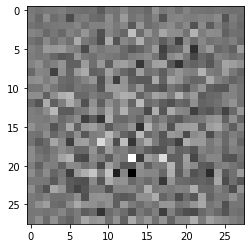

In [6]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00349441]], shape=(1, 1), dtype=float32)


In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [23]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      g_loss,d_loss = train_step(image_batch)

    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec, G_loss = {}, D_loss = {}'.format(epoch + 1, time.time()-start,g_loss,d_loss))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

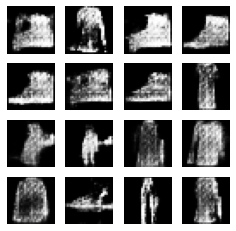

Time for epoch 1 is 6.300480842590332 sec, G_loss = 1.920229434967041, D_loss = 0.6367003321647644


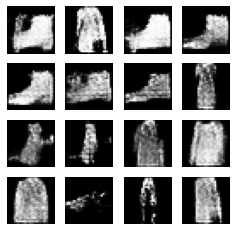

Time for epoch 2 is 6.2825682163238525 sec, G_loss = 1.3844726085662842, D_loss = 0.9335387945175171


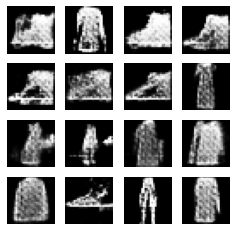

Time for epoch 3 is 6.441577911376953 sec, G_loss = 1.7811390161514282, D_loss = 0.8594925403594971


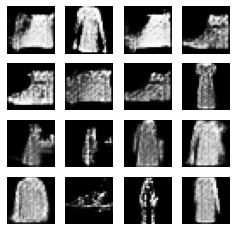

Time for epoch 4 is 6.28858757019043 sec, G_loss = 1.2816606760025024, D_loss = 1.0896902084350586


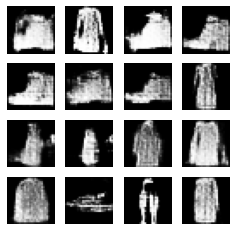

Time for epoch 5 is 6.272086143493652 sec, G_loss = 1.405165433883667, D_loss = 1.0547523498535156


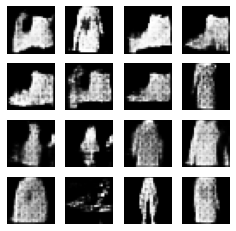

Time for epoch 6 is 6.421678781509399 sec, G_loss = 1.4540412425994873, D_loss = 1.0973138809204102


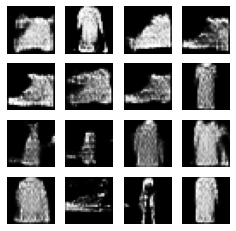

Time for epoch 7 is 6.277722120285034 sec, G_loss = 1.5446853637695312, D_loss = 0.8926353454589844


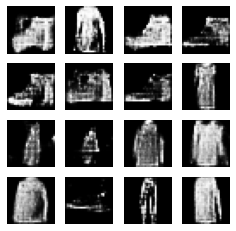

Time for epoch 8 is 6.290801525115967 sec, G_loss = 1.837388277053833, D_loss = 0.8406952619552612


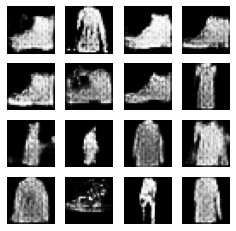

Time for epoch 9 is 6.4409568309783936 sec, G_loss = 1.656039834022522, D_loss = 0.8844696283340454


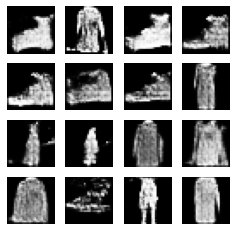

Time for epoch 10 is 6.295661449432373 sec, G_loss = 1.33319091796875, D_loss = 1.0967742204666138


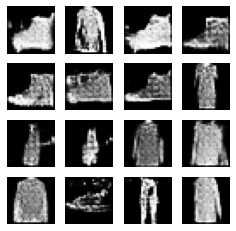

Time for epoch 11 is 6.425192832946777 sec, G_loss = 1.5812782049179077, D_loss = 1.2020113468170166


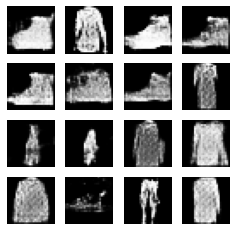

Time for epoch 12 is 6.291827440261841 sec, G_loss = 1.4351109266281128, D_loss = 0.8846983909606934


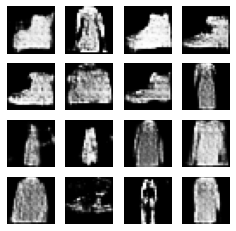

Time for epoch 13 is 6.281774044036865 sec, G_loss = 1.093923807144165, D_loss = 1.0133646726608276


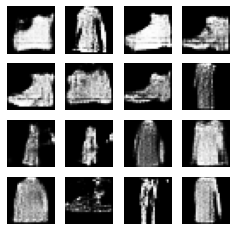

Time for epoch 14 is 6.416781663894653 sec, G_loss = 1.3578537702560425, D_loss = 0.9558566808700562


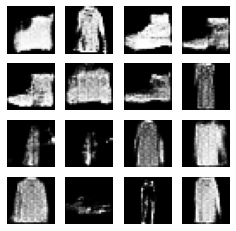

Time for epoch 15 is 6.348052024841309 sec, G_loss = 1.4762946367263794, D_loss = 0.8627071380615234


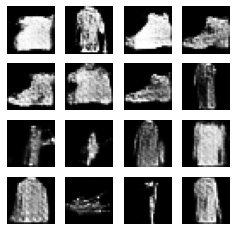

Time for epoch 16 is 6.2804930210113525 sec, G_loss = 1.6876909732818604, D_loss = 0.9593458771705627


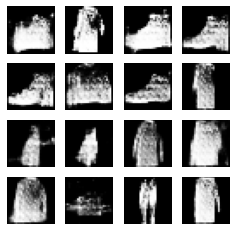

Time for epoch 17 is 6.441077947616577 sec, G_loss = 1.5067172050476074, D_loss = 0.8454453945159912


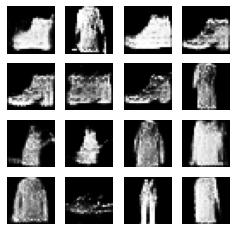

Time for epoch 18 is 6.273735046386719 sec, G_loss = 1.8918070793151855, D_loss = 0.7956044673919678


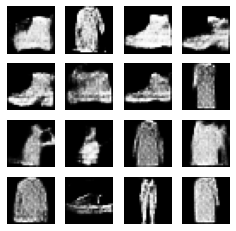

Time for epoch 19 is 6.272080421447754 sec, G_loss = 1.3143420219421387, D_loss = 0.9773271083831787


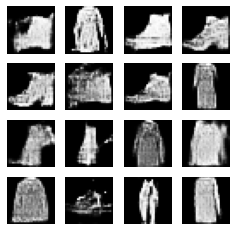

Time for epoch 20 is 6.4325642585754395 sec, G_loss = 1.2642099857330322, D_loss = 0.9344708323478699


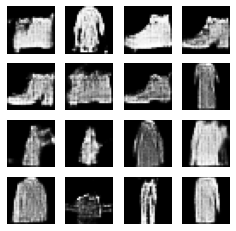

Time for epoch 21 is 6.269316911697388 sec, G_loss = 1.3058905601501465, D_loss = 0.924079418182373


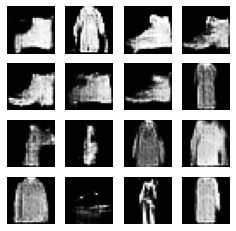

Time for epoch 22 is 6.279221534729004 sec, G_loss = 1.5875636339187622, D_loss = 0.8960142731666565


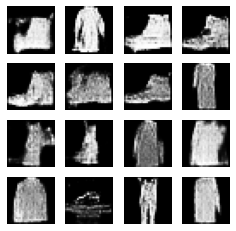

Time for epoch 23 is 6.429149866104126 sec, G_loss = 1.3526885509490967, D_loss = 1.093254804611206


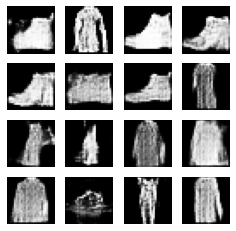

Time for epoch 24 is 6.275866270065308 sec, G_loss = 1.2754237651824951, D_loss = 1.0141304731369019


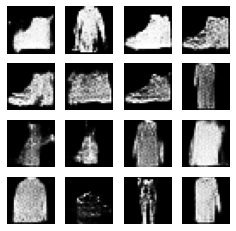

Time for epoch 25 is 6.294682741165161 sec, G_loss = 1.6190389394760132, D_loss = 0.9382866621017456


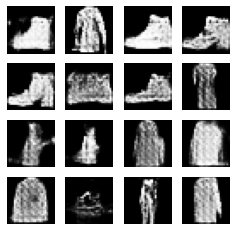

Time for epoch 26 is 6.424190282821655 sec, G_loss = 1.51412034034729, D_loss = 0.8791062831878662


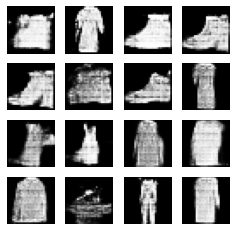

Time for epoch 27 is 6.282598972320557 sec, G_loss = 1.2204782962799072, D_loss = 0.9696075916290283


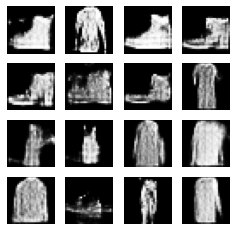

Time for epoch 28 is 6.275319576263428 sec, G_loss = 1.2659255266189575, D_loss = 1.0268733501434326


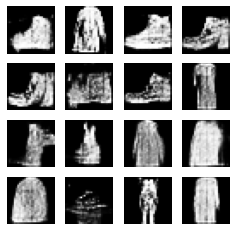

Time for epoch 29 is 6.424938201904297 sec, G_loss = 1.4107567071914673, D_loss = 0.9675658941268921


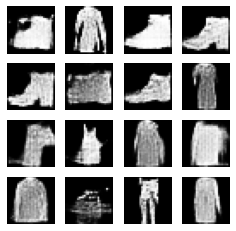

Time for epoch 30 is 6.35385537147522 sec, G_loss = 1.1966272592544556, D_loss = 1.1066193580627441


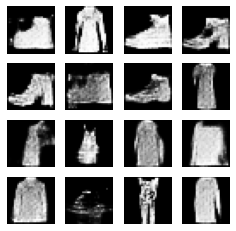

Time for epoch 31 is 6.271704912185669 sec, G_loss = 1.1414289474487305, D_loss = 0.987530529499054


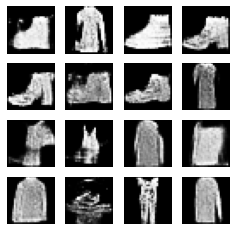

Time for epoch 32 is 6.419996023178101 sec, G_loss = 1.2292594909667969, D_loss = 1.058463215827942


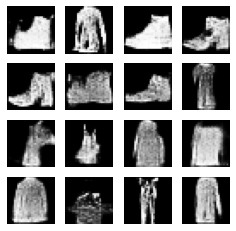

Time for epoch 33 is 6.276212453842163 sec, G_loss = 1.3517341613769531, D_loss = 1.0332401990890503


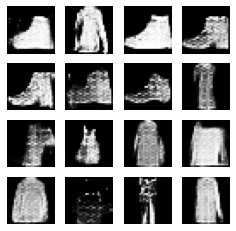

Time for epoch 34 is 6.272195100784302 sec, G_loss = 1.4292333126068115, D_loss = 0.909989595413208


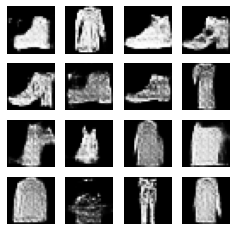

Time for epoch 35 is 6.440238952636719 sec, G_loss = 1.4377819299697876, D_loss = 0.9250563979148865


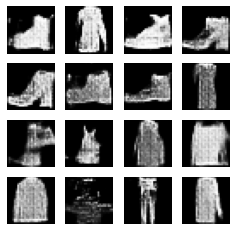

Time for epoch 36 is 6.274763345718384 sec, G_loss = 1.412627100944519, D_loss = 0.9537548422813416


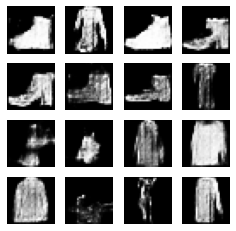

Time for epoch 37 is 6.277993440628052 sec, G_loss = 1.2509492635726929, D_loss = 1.1337393522262573


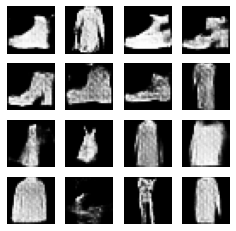

Time for epoch 38 is 6.447731256484985 sec, G_loss = 1.296409249305725, D_loss = 1.076448917388916


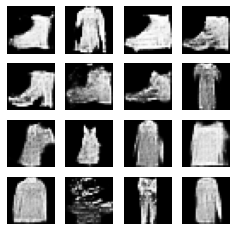

Time for epoch 39 is 6.2857630252838135 sec, G_loss = 1.3460309505462646, D_loss = 0.9792746901512146


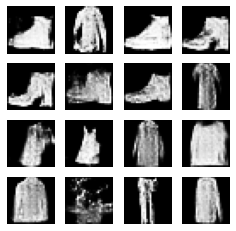

Time for epoch 40 is 6.27869987487793 sec, G_loss = 1.3220053911209106, D_loss = 1.1180020570755005


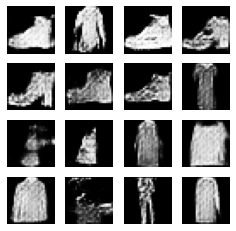

Time for epoch 41 is 6.419832468032837 sec, G_loss = 1.182525396347046, D_loss = 1.0880073308944702


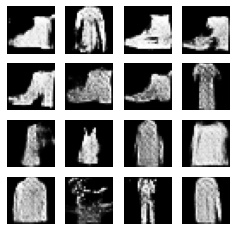

Time for epoch 42 is 6.305041790008545 sec, G_loss = 1.523688793182373, D_loss = 0.9869574904441833


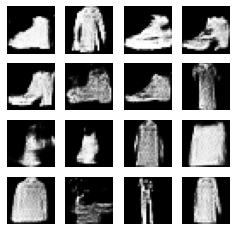

Time for epoch 43 is 6.286471843719482 sec, G_loss = 1.3655486106872559, D_loss = 1.098597764968872


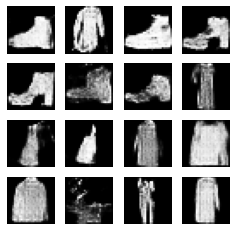

Time for epoch 44 is 6.433315753936768 sec, G_loss = 1.3612440824508667, D_loss = 0.9475486278533936


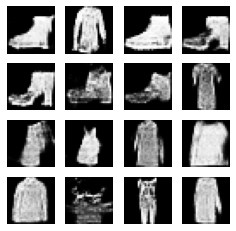

Time for epoch 45 is 6.37903904914856 sec, G_loss = 1.179582118988037, D_loss = 1.2449767589569092


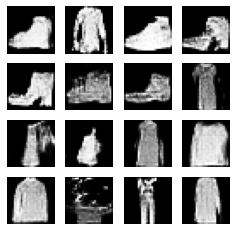

Time for epoch 46 is 6.264045476913452 sec, G_loss = 1.3497908115386963, D_loss = 1.024154782295227


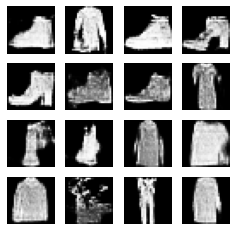

Time for epoch 47 is 6.441449403762817 sec, G_loss = 1.0398751497268677, D_loss = 1.0987555980682373


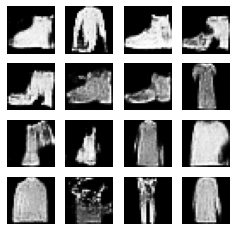

Time for epoch 48 is 6.290416717529297 sec, G_loss = 1.1427148580551147, D_loss = 1.0913538932800293


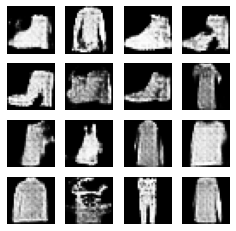

Time for epoch 49 is 6.317722320556641 sec, G_loss = 1.1318119764328003, D_loss = 1.0701801776885986


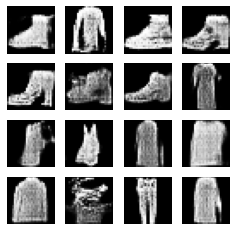

Time for epoch 50 is 6.489439964294434 sec, G_loss = 1.2133091688156128, D_loss = 1.116089105606079


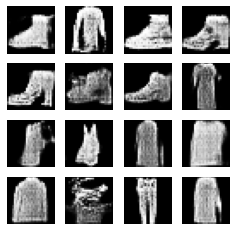

In [24]:
train(train_dataset, EPOCHS)